## Working Version - Container Transfer Hub

**Example description:** Example of a container transfer hub, where very large container vessels deliver containers, while smaller vessels take care of the distribution to the hinterland.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style
import pyproj

# package(s) for data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# digital twin package
import digital_twin.core as core1
import digital_twin.model as model1
import digital_twin.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx

# Used for mathematical functions
import math

# transport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.model as model

# Vessel database
location_vessel_database = "Vessels/richtlijnen-duwbakken-2017.csv"

In [2]:
# Create simulation environment
simulation_start = datetime.datetime(2019, 1, 1)

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions

#### Create objects and specify the properties for sites you wish to create

In [3]:
def connect_sites_with_path(data_from_site, data_to_site, data_node, path):
    Nodes = []
    Edges = []
    Site = type('Site', (core1.Identifiable, # Give it a name
             core1.Log,          # Allow logging of all discrete events
             core1.Locatable,    # Add coordinates to extract distance information and visualize
             core1.HasContainer, # Add information on the material available at the site
             core1.HasResource), # Add information on serving equipment
    {})                               # The dictionary is empty because the site type is generic

    Node = type('Node', (core1.Identifiable, # Give it a name
             core1.Log,                      # Allow logging of all discrete events
             core1.Locatable),               # Add coordinates to extract distance information and visualize
    {})                                           # The dictionary is empty because the site type is generic
    
#     Edge = type('Edge', (core.Identifiable, # Give it a name
#              core.Log,           # Allow logging of all discrete events
#              core.Locatable,    # Add coordinates to extract distance information and visualize
#              core.HasWeather),  # Add water levels to waterways
#     {})

    for i, j in enumerate(path):
        if i == 0:
            data_from_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_from_site))

        elif i == len(path) - 1:
            data_to_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_to_site))
            Edges.append([Nodes[i-1], Nodes[i]])
            
        else:
            data_node["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            data_node["name"]='node-' + str(i)
            node = Node(**data_node)
            node.name = node.id
            Nodes.append(node)
            Edges.append([Nodes[i-1], Nodes[i]])
            
    return Nodes, Edges

In [4]:
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Origin locatie",       # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": 10_000_000,         # The capacity of the site
                  "level": 10_000_000}            # The actual volume of the site

data_inter_site = {"env": my_env,                 # The simpy environment defined in the first cel
                "name": "Overslag locatie",       # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 100_000_000,           # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site1 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Nijmegen",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_to_site2 = {"env": my_env,                   # The simpy environment defined in the first cel
                "name": "Haven Deventer",         # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 5_000_000,            # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

data_node = {"env": my_env,                       # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the waterway
                 "geometry": []}                  # The coordinates of the project site


In [5]:
path_from_to_inter = [[3.223979059949225,52.03276781167011],
                        [3.656045091181079,52.04776907241202],
                        [3.953697524848219,52.02803067898825],
                        [4.067560378249368,51.95173269362142]]

In [6]:
path_inter_to_destination1 = [[4.067560378249368,51.95173269362142],
                             [5.260911,51.820500],
                             [5.830619709457634,51.86183419049677],
                             [5.830727947258836,51.86102575658615]]

In [7]:
path_inter_to_destination2 = [[4.067560378249368,51.95173269362142],
                             [5.937599,51.964640],
                             [6.197050,52.092425],
                             [6.172119444444445,52.247375]]

#### Finally create specific instances of the predefined objects with the specified properties

In [8]:
Nodes1, Edges1 = connect_sites_with_path(data_from_site, data_inter_site, data_node, path_from_to_inter)
Nodes2, Edges2 = connect_sites_with_path(data_inter_site, data_to_site1, data_node, path_inter_to_destination1)
Nodes3, Edges3 = connect_sites_with_path(data_inter_site, data_to_site2, data_node, path_inter_to_destination2)

#### Create graph

Origin locatie
fa73dedc-6c0b-11e9-96e3-9061aef054a5
fa73dedd-6c0b-11e9-8be9-9061aef054a5
Overslag locatie
Origin locatie - fa73dedc-6c0b-11e9-96e3-9061aef054a5
fa73dedc-6c0b-11e9-96e3-9061aef054a5 - fa73dedd-6c0b-11e9-8be9-9061aef054a5
fa73dedd-6c0b-11e9-8be9-9061aef054a5 - Overslag locatie
Overslag locatie
fa73dee0-6c0b-11e9-b474-9061aef054a5
fa73dee1-6c0b-11e9-99c1-9061aef054a5
Haven Nijmegen
Overslag locatie - fa73dee0-6c0b-11e9-b474-9061aef054a5
fa73dee0-6c0b-11e9-b474-9061aef054a5 - fa73dee1-6c0b-11e9-99c1-9061aef054a5
fa73dee1-6c0b-11e9-99c1-9061aef054a5 - Haven Nijmegen
Overslag locatie
fa73f37a-6c0b-11e9-b1c4-9061aef054a5
fa740666-6c0b-11e9-ad17-9061aef054a5
Haven Deventer
Overslag locatie - fa73f37a-6c0b-11e9-b1c4-9061aef054a5
fa73f37a-6c0b-11e9-b1c4-9061aef054a5 - fa740666-6c0b-11e9-ad17-9061aef054a5
fa740666-6c0b-11e9-ad17-9061aef054a5 - Haven Deventer


C:\Users\serva\Documents\Thesis\Modelleren\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



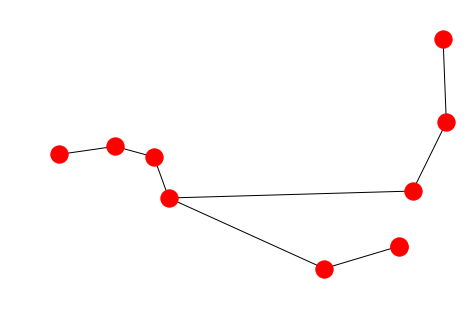

In [9]:
def add_path_to_graph(G, positions, Nodes, Edges):
    
    for node in Nodes:
        print(node.name)
        positions[node.name] = (node.geometry.x, node.geometry.y)
        G.add_node(node.name, geometry = node.geometry)
        
    for edge in Edges:
        print(edge[0].name + ' - ' + edge[1].name)
        G.add_edge(edge[0].name, edge[1].name, weight = 1)
        
    return G, positions

positions = {}
G = nx.Graph()

G, positions = add_path_to_graph(G, positions, Nodes1, Edges1)
G, positions = add_path_to_graph(G, positions, Nodes2, Edges2)
G, positions = add_path_to_graph(G, positions, Nodes3, Edges3)

nx.draw(G, positions)

my_env.G = G

In [10]:
# #Koppelen van water levels aan Edges. Dit lijstje wordt op den duur vervangen door een lijst die uit Sobek moet rollen.
# water_levels1 = [1, 2, 3]

# #For Nodes1 and Edges1
# for i in range(len(Edges1)):
#     edge_attribute_dict = {
#         (Nodes1[i].name, Nodes1[i+1].name) : {"water level": water_levels1[i]},
#         }
#     nx.set_edge_attributes(FG, edge_attribute_dict)

# print(FG.edges(data=True))

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - A moving container, so capacity and location
    core.Processor - Allow for loading and unloading
    core.HasResource - Add information on serving equipment
    core.HasDepthRestriction - Add information on depth restriction 

#### First create objects with the desired properties

In [11]:
vessel_db = pd.read_csv(location_vessel_database)
vessel_db.head(5)
# print(vessel_db.loc[:, 'vessel_type'])

,vessel_id,vessel_type,width,length,draught_empty,draught_full,capacity
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.2,55.0,0.6,1.90,400
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.6,65.0,0.6,2.60,500
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.2,85.0,0.6,2.70,925
3,208a5aca-4aef-11e9-b7e9-b469212bff5,CEMT - IV,9.5,70.0,0.6,3.00,1450
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.4,115.0,0.6,3.75,2875


In [12]:

# TransportProcessingResource = type('TransportProcessingResource', 
#                                    (core.Identifiable,              # Give it a name
#                                     core.Log,                       # Allow logging of all discrete events
#                                     core.ContainerDependentMovable, # A moving container, so capacity and location
#                                     core.Processor,                 # Allow for loading and unloading
#                                     core.HasResource,               # Add information on serving equipment
#                                     core.HasSoil,                   # Add soil object, because it moves soil
#                                     core.Routeable,                 # Initialize spill terms
#                                     core.HasDepthRestriction),      # Draught (related to loading) is limited by depth
#                                    {})

# The generic class for an object that can transport

Vessel = type('Vessel',
              (core.Identifiable, 
               core.Log, 
               core1.ContainerDependentMovable,
               core.VesselProperties, 
               core1.Processor, 
               core.HasResource, 
               core.Routeable), 
              {})

In [25]:
generator = model.VesselGenerator(Vessel, vessel_db)
print(generator)
# print(Vessel.VesselProperties)

#### Next specify the properties for vessel(s) you wish to create

In [19]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda filling: filling * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda current_level, desired_level: (desired_level - current_level) / rate

def compute_unloading(rate):
    return lambda current_level, desired_level: (current_level - desired_level) / rate

In [20]:
# Draught of the vessel is dependent on the degree of filling
def draught_vessel(draught_empty, draught_full):
    return lambda filling: filling * (draught_full - draught_empty) + draught_empty


In [21]:
vessel_stats = {"env": my_env,
               "name": "Seagoing",
               "geometry": Nodes1[0].geometry,
               "loading_func": compute_loading(1.5),
               "unloading_func": compute_unloading(1.5),
               "compute_v": compute_v_provider(5, 4.5),
#                "capacity": 5_000,
               }

In [30]:
vessels = []

vessel = Vessel(**vessel_stats)
vessel.__dict__

# for i in range(10):
#     vessel = Vessel(**vessel_stats)
#     vessel.name = "Vessel " + str(i+1)
# #     vessel.capacity = vessel_db[i, -1]

#     vessels.append(vessel)

print(vessels)

TypeError: __init__() missing 1 required positional argument: 'capacity'

In [23]:
# # Large container vessel variables
# data_container_large = {"env": my_env,                              # The simpy environment 
#                "name": "Container large",                           # Name
#                "geometry": Nodes1[0].geometry,                      # It starts at the "from site"
#                "loading_func": compute_loading(1.5),                # Loading rate
#                "unloading_func": compute_unloading(1.5),            # Unloading rate
#                "capacity": vessel_db[5, 9],                                  # Capacity of the container vessel - TEU
#                "compute_v": compute_v_provider(5, 4.5),             # Variable speed
#                "compute_draught": draught_vessel(vessel_db[5, 7], vessel_db[5, 8]),             # Variable draught of the vessel
#                }

In [ ]:
# # Small container vessel variables
# data_container_small_01 = {"env": my_env,                           # The simpy environment 
#                "name": "Container small_01",                        # Name
#                "geometry": Nodes1[-1].geometry,                     # It starts at the "inter site"
#                "loading_func": compute_loading(1.5),                # Loading rate
#                "unloading_func": compute_unloading(1.5),            # Unloading rate
#                "capacity": 5_000,                                   # Capacity of the container vessel - TEU
#                "compute_v": compute_v_provider(5, 4.5),             # Variable speed
#                "compute_draught": draught_vessel(1, 2),             # Variable draught of the vessel
#                 }

In [ ]:
# # Small container vessel variables
# data_container_small_02 = {"env": my_env,                           # The simpy environment 
#                "name": "Container small_02",                        # Name
#                "geometry": Nodes1[-1].geometry,                     # It starts at the "inter site"
#                "loading_func": compute_loading(1.5),                # Loading rate
#                "unloading_func": compute_unloading(1.5),            # Unloading rate
#                "capacity": 5_000,                                   # Capacity of the container vessel - TEU
#                "compute_v": compute_v_provider(5, 4.5),             # Variable speed
#                "compute_draught": draught_vessel(1, 2),             # Variable draught of the vessel
#                 }

#### Finally create specific instances of the predefined objects with the specified properties

In [ ]:
# # The simulation object
# container_large = Vessel(**vessel_data)
# container_small_01 = Vessel(**data_container_small_01)
# container_small_02 = Vessel(**data_container_small_02)

In [ ]:
# def start(my_env, vessel):
#     while True:
        
#         vessel.log_entry("Start sailing", my_env.now, "0", vessel.geometry)
#         yield from vessel.move()
#         vessel.log_entry("Stop sailing", my_env.now, "0", vessel.geometry)

#         if vessel.geometry == nx.get_node_attributes(my_env.G, "geometry")[vessel.route[-1]]:
#             break

In [ ]:
# vessels = []

# # random_1 = random.choice(list(G))
# # print(random_1)

# # Add 10 vessels to the simulation
# for i in range(100):
#     path = nx.dijkstra_path(G, Nodes1[0].name, Nodes1[-1].name)

    
#     vessel = generator.generate(my_env, "Vessel " + str(i))
#     vessel.route = path
# #   vessel.compute_v = compute_v_provider(5, 4.5)
#     vessel.geometry = nx.get_node_attributes(my_env.G, "geometry")[vessel.route[0]]
#     vessels.append(vessel)
    
#     # Add the movements of the vessel to the simulation
#     env.process(start(my_env, vessel))

### 1.3 Define the activity

In [ ]:
# # conditie dat intermediate niet leeg is
# condition = model.LevelCondition(container=intermediate.container, min_level=1)  

# # conditie dat een jaar verstreken is
# stop_condition = modelTimeCondition(…)  
 
# activity_2 = model.Activity(…, 
# start_condition = None,  # laat de activiteit meteen starten als de simulatie begint
# condition = condition,  # steeds als tussendoor de intermediate container leeg is, wacht een uur en check daarna nog eens
# stop_condition = stop_condition)  # de activiteit eindigt als een jaar verstreken is
# (idem voor activity_3)


In [ ]:
# Continuous simulation, stop after one year
condition = model.LevelCondition(container=Nodes1[0], min_level=1)
condition_1 = model.LevelCondition(container=Nodes1[-1], min_level=1)
stop_condition = model.TimeCondition(my_env, datetime.datetime(2019, 1, 1), datetime.datetime(2022, 1, 1))



In [ ]:
# Create activity
activity_1 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "International transport", # We are moving soil
                          origin = Nodes1[0],               # We originate from the from_site
                          destination = Nodes1[-1],         # And therefore travel to the to_site
                          loader = container_large,         # The benefit of a TSHD, all steps can be done
                          mover = container_large,          # The benefit of a TSHD, all steps can be done
                          unloader = container_large,       # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition,            # Activity runs until Origin is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

In [ ]:
# Create activity                      
activity_2 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Nijmegen",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes2[-1],         # And therefore travel to the to_site
                          loader = container_small_01,      # The benefit of a TSHD, all steps can be done
                          mover = container_small_01,       # The benefit of a TSHD, all steps can be done
                          unloader = container_small_01,    # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition_1,          # Activity runs until Intermediate is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

In [ ]:
# Create activity                      
activity_3 = model.Activity(env = my_env,                   # The simpy environment defined in the first cel
                          name = "Hinterland transport Deventer",    # We are moving soil
                          origin = Nodes1[-1],              # We originate from the from_site
                          destination = Nodes3[-1],         # And therefore travel to the to_site
                          loader = container_small_02,      # The benefit of a TSHD, all steps can be done
                          mover = container_small_02,       # The benefit of a TSHD, all steps can be done
                          unloader = container_small_02,    # The benefit of a TSHD, all steps can be done
                          start_condition = None,           # We can start right away and do not stop
                          condition = condition_1,          # Activity runs until Intermediate is empty
                          stop_condition = stop_condition)            # Stop after 1 year simulation

### 2. Run the simulation

In [ ]:
my_env.run()

print("\n*** Transportation of containers finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))

### 3. Postprocessing

In [ ]:
vessels = [container_large, container_small_01, container_small_02]
# print(vessels)

# import pandas as pd
# df = pd.DataFrame.from_dict(vessels[0].log)
# df

In [ ]:
Nodes1[0].container.level

In [ ]:
Nodes1[-1].container.level

In [ ]:
for j in Nodes2[-1].log['Value']:
    while Nodes2[-1].log['Value'][j] < Nodes2[-1].container.capacity:
        j = j + 1
    else:
        print('Capacity of Nijmegen port is reached on', Nodes2[-1].log['Timestamp'][j])
        print('Capacity of Nijmegen port is reached after', Nodes2[-1].log['Timestamp'][j] - (datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)))
        break

In [ ]:
for j in Nodes3[-1].log['Value']:
    while Nodes3[-1].log['Value'][j] < Nodes2[-1].container.capacity:
        j = j + 1
    else:
        print('Capacity of Deventer port is reached on', Nodes3[-1].log['Timestamp'][j])
        print('Capacity of Deventer port is reached after', Nodes3[-1].log['Timestamp'][j] - (datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)))
        break

#### Vessel planning

In [ ]:
activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### KML visualisation

In [ ]:
# plot.vessel_kml(my_env, vessels, stepsize = 10000)

In [ ]:
# plot.site_kml(my_env, [Nodes1[0], Nodes1[-1], Nodes2[-1], Nodes3[-1]], stepsize = 10000)

In [ ]:
# #Open the file
# if platform.system():
#     !start ./vessel_movements.kml
#     !start ./site_development.kml
# else:
#     !start explorer ./vessel_movements.kml
#     !start explorer ./site_development.kml

In [ ]:
# Properties toewijzen aan Edges
# for edge in FG.edges(data = True):
#     print(edge)

In [ ]:
# vessels[0].compute_draught

In [ ]:
# a = Nodes3[-1].log['Timestamp'][j]
# import pytz
# b = datetime.datetime(1970, 1, 1, 1, 0, 0) + datetime.timedelta(seconds=my_env.epoch)
# print(a)
# print(b)
# print(a-b)